In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import numpy as np
import re
nltk.download('punkt')
from nltk.corpus import stopwords
from pandas import read_csv
import collections
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss,confusion_matrix,classification_report, accuracy_score
from nltk.tokenize import RegexpTokenizer

import itertools

[nltk_data] Downloading package punkt to /Users/szkhome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.time_layers import *
from common.np import *  
from common.base_model import BaseModel

# 問題：Backpropagationで勾配爆発、勾配消失が起こる

## 実験１：勾配爆発

In [3]:
N = 2 #Minibatch
H = 3 #Hidden状態ベクトルの次元数
T = 20 #時系列データの長さ

dh=np.ones((N, H)) #dhをnp.onesで初期化する
np.random.seed(3)
Wh=np.random.randn(H,H)

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N #L2ノルムを求める（各要素の２条の総和に対してSQRTを適用）
    norm_list.append(norm)


[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


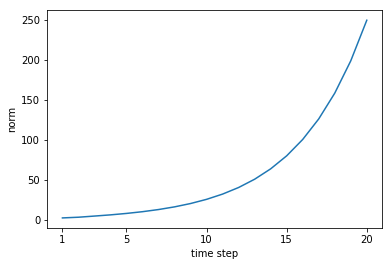

In [4]:
print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配の大きさが、時間とともに、指数的に増加していることがわかります。勾配爆発が見られました。勾配爆発がおこると、オーバーフローを起こして最後はNaNのような値が発生することになります。そのためNNは正しい学習を行えなくなります。

## 実験２：勾配消失

In [5]:
N = 2 #Minibatch
H = 3 #Hidden状態ベクトルの次元数
T = 20 #時系列データの長さ

dh=np.ones((N, H)) #dhをnp.onesで初期化する
np.random.seed(3)
#Wh=np.random.randn(H,H) #before
Wh=np.random.randn(H,H)*0.5 #after

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N #L2ノルムを求める（各要素の２条の総和に対してSQRTを適用）
    norm_list.append(norm)


[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]


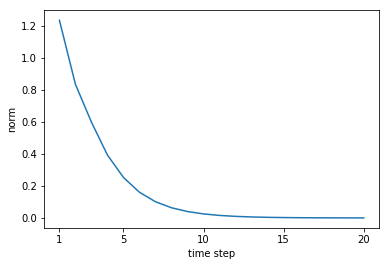

In [6]:
print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配消失しました。初期値で半分にした値（Wh）をT回繰り返し乗算しているから、指数的な変化が起こっていることがわかります。

# 対策

## 勾配爆発への対策: Clipping

定番の方法：Clippingを行います。LSTMでは定番の方法とのことです。

In [7]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm=0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
        
    total_norm =np.sqrt(total_norm)
    
    rate=max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
            
clip_grads(grads, max_norm)

## 勾配消失への対策: ゲート付きRNN（ここではLSTM）

RNNでの学習では、勾配消失も大きな問題になります。勾配消失に関しては、先ほども見たように、T回の乗算をしていくことになっているので、簡単に起こってしまいます。
そのため、勾配消失問題を解決しようと思うと、RNNのアーキテクチャーを変更するということが手段の一つになります。ここではアーキテクチャーを変える「ゲート付きRNN」がひとつ解になります。というのも、ゲート付きは、cという専用の記憶部が存在するからです。ここでは、ゲート付きRNNのひとつであるLSTMを実装し、これを対策とします。

結論から言うと、なぜLSTMでは勾配消失がおきないかというと、記憶せるCを作り、ここの逆伝播に、単純に＋と×しかないからです。

またその×部分も、行列の積ではなく、要素ごとのアダマール積であるため起こしにくい理由があります。しかもその×ノードの計算は、forgetゲートによってコントロールされており、ここでforgetゲートが忘れるべきと判断したものは、その勾配の要素は小さくなりますが、忘れないと導いた要素は。その勾配のう要素を劣化させることなく過去方向へ伝えら得ることになります。以上のことから、勾配消失がおきにくいことが期待できることになります。特に長期に渡って覚えておくべき情報に関しては、記憶セルが保持していることになります。


(4つのアフィン変換の方)

In [8]:
class LSTM:

    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


# LSTMをTの時間個分回せるようにする（Time RNNとほぼ同じ）

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


ゲートはデータの流れをコントロールします。ゲートの開き具合は、０−１までの実数で表されます。その数値によって、次へ流す水の量をコントロールするのです。ちなみにゲートの開き具合はSigmoid関数で表します。


一方、実質的な「情報」を持つデータにはtanj関数が活性化関数として用いられる。

下記には、上記の層を追加したものを実装します。

# LSTM二重化したものの実装

LSTMレイヤを2層利用し、各層にDropoutを使う。

In [ ]:
class BetterRnnlm(BaseModel):

    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100)
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D))
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H))
        lstm_b1 = np.zeros(4 * H)
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H))
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H))
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

# 学習する(副読本通り）

In [ ]:
# # coding: utf-8
# import sys
# sys.path.append('..')
# from common import config
# # GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# # ==============================================
# # config.GPU = True
# # ==============================================
# from common.optimizer import SGD
# from common.trainer import RnnlmTrainer
# from common.util import eval_perplexity, to_gpu
# from dataset import ptb
# from better_rnnlm import BetterRnnlm

In [ ]:
# # ハイパーパラメータの設定
# batch_size = 20
# wordvec_size = 650
# hidden_size = 650
# time_size = 35
# lr = 20.0
# max_epoch = 1
# max_grad = 0.25
# dropout = 0.5

In [ ]:
# # 学習データの読み込み
# corpus, word_to_id, id_to_word = ptb.load_data('train')
# corpus_val, _, _ = ptb.load_data('val')
# corpus_test, _, _ = ptb.load_data('test')

# if config.GPU:
#     corpus = to_gpu(corpus)
#     corpus_val = to_gpu(corpus_val)
#     corpus_test = to_gpu(corpus_test)

# vocab_size = len(word_to_id)
# xs = corpus[:-1]
# ts = corpus[1:]

In [ ]:
# model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
# optimizer = SGD(lr)
# trainer = RnnlmTrainer(model, optimizer)

# best_ppl = float('inf')
# for epoch in range(max_epoch):
#     trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
#                 time_size=time_size, max_grad=max_grad)

#     model.reset_state()
#     ppl = eval_perplexity(model, corpus_val)
#     print('valid perplexity: ', ppl)

#     if best_ppl > ppl:
#         best_ppl = ppl
#         model.save_params()
#     else:
#         lr /= 4.0
#         optimizer.lr = lr

#     model.reset_state()
#     print('-' * 50)

In [ ]:
# # テストデータでの評価
# model.reset_state()
# ppl_test = eval_perplexity(model, corpus_test)
# print('test perplexity: ', ppl_test)

# Womens Clothing Reviewでやる

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/szkhome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
dataset = read_csv('./Womens Clothing E-Commerce Reviews.csv')
reviews = dataset['Review Text'].astype('str')
#recommend = dataset['Recommended IND']

In [33]:
dataset.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [34]:
reviews.head()

0    Absolutely wonderful - silky and sexy and comf...
1    Love this dress!  it's sooo pretty.  i happene...
2    I had such high hopes for this dress and reall...
3    I love, love, love this jumpsuit. it's fun, fl...
4    This shirt is very flattering to all due to th...
Name: Review Text, dtype: object

## データセットをtextという変数に入れる

In [35]:
text = dataset[['Review Text']]
text

,Review Text
0,Absolutely wonderful - silky and sexy and comf...
1,Love this dress! it's sooo pretty. i happene...
2,I had such high hopes for this dress and reall...
3,"I love, love, love this jumpsuit. it's fun, fl..."
4,This shirt is very flattering to all due to th...
5,"I love tracy reese dresses, but this one is no..."
6,I aded this in my basket at hte last mintue to...
7,"I ordered this in carbon for store pick up, an..."
8,I love this dress. i usually get an xs but it ...
9,"I'm 5""5' and 125 lbs. i ordered the s petite t..."


## 欠損を処理する

In [36]:
text['Review Text'][0]
text[text['Review Text']==""]=np.NaN
text['Review Text'].fillna("No Review",inplace=True)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/pandas/core/frame.py:2434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.ix._setitem_with_indexer(indexer, value)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/pandas/core/frame.py:2414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/panda

## TrainとValidationとTestに分ける

In [37]:
split = np.random.randn(len(text)) <0.6
train = text[split]
val_candidates = text[~split]
print("トータルの行数は  train:",len(train),"and val_candidates:",len(val_candidates))

トータルの行数は  train: 17084 and val_candidates: 6402


In [38]:
split = np.random.randn(len(val_candidates)) <0.5
validation = val_candidates[split]
test = val_candidates[~split]
print("トータルの行数は  validation:",len(validation),"and test:",len(test))

トータルの行数は  validation: 4408 and test: 1994


# 前処理

ここまでは、Dataframeに入っていますので、arrayに直します。


またリストに入っていますので行にまとめます。

文字列のリスト（配列）を連結・結合: join()。文字列メソッドjoin()を使うと、文字列のリストを一つの文字列に連結することができる。

書き方は以下の通り。

- 間に挿入する文字列'.join([連結したい文字列のリスト])
- 間に挿入する文字列'でjoin()メソッドを呼び出し、引数として[連結したい文字列のリスト]を渡す。

空文字列を使えば[連結したい文字列のリスト]が単純連結されるし、カンマ,を使えばカンマ区切りの文字列となり、改行文字\nを使えば文字列要素ごとに改行される。

## 行をまとめる、正規表現を使っていらない文字を消す。

In [85]:
#np.arrayにする
train=np.array(train)
train=str(train)

validation=np.array(validation)
validation=str(validation)

test=np.array(test)
test=str(test)

In [86]:
# joinによって１行にする
train = ''.join(train)
validation = ''.join(validation)
test = ''.join(test)

In [87]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [88]:
# Review データの変換をする

def review_prepare(review):
    review = review.lower()# lowercase text
    review = re.sub(REPLACE_BY_SPACE_RE," ",review)# replace REPLACE_BY_SPACE_RE symbols by space in text
    review = re.sub(BAD_SYMBOLS_RE,"",review)# delete symbols which are in BAD_SYMBOLS_RE from text
    review = re.sub(' +',' ',review)
    #review = " ".join([word for word in review.split() if word not in STOPWORDS]) # delete stopwords from text
    return review

In [43]:
train=review_prepare(train)
validation=review_prepare(validation)
test=review_prepare(test)

In [23]:
# train = [review_prepare(train) for train in reviews]
# validation = [review_prepare(validation) for train in reviews]
# test = [review_prepare(test) for train in reviews]

In [89]:
train

' absolutely wonderful silky and sexy and comfortable love this dress its sooo pretty i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite i bought a petite and am 58 i love the length on me hits just a little below the knee would definitely be a true midi on someone who is truly petite i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper it c i was very happy to snag this dress at such a great price its very easy to slip on and has a very flattering cut and color combo this fit well but the top was very see throug

## 前処理をする

In [45]:
## 前処理をする

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word



In [46]:
# 学習データの読み込み
corpus, word_to_id, id_to_word = preprocess(train)
corpus_val, _, _ = preprocess(validation)
corpus_test, _, _ = preprocess(test)

In [47]:
# def maeshori3(data):
#     gyou = []
#     word_to_ids =[]
#     id_to_words =[]
#     length=len(data[:10])
#     for i in range(length):

#         text=data[:10][i][0]
#         text = text.lower()
#         text = text.replace('.', ' .')
#         words = text.split(' ')

#         word_to_id = {}
#         id_to_word = {}

#         for word in words:
#             if word not in word_to_id:
#                 new_id = len(word_to_id)
#                 word_to_id[word] = new_id
#                 id_to_word[new_id] = word
#         corpus = np.array([word_to_id[w] for w in words])
#         gyou.append(corpus)
#         word_to_ids.append(word_to_id)
#         id_to_words.append(id_to_word)
#     #print(gyou[0])
#     return gyou, word_to_ids, id_to_words

## create_contexts_targetとは？(Target)

In [48]:
def create_contexts_target(corpus, sliding_window_size=1):

    target = corpus[sliding_window_size:-sliding_window_size]
    contexts = []

    for idx in range(sliding_window_size, len(corpus)-sliding_window_size):
        cs = []
        for t in range(-sliding_window_size, sliding_window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [49]:
contexts, target = create_contexts_target(corpus, sliding_window_size=1)

ところが、このデータはそもそもOne Hotにしないといけないので、OneHotします

## create_contexts_targetとは？(One-Hotするやつ)

In [50]:
corpus.shape[0]

257

In [51]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

One-Hotの前にVocabサイズを定義します

In [52]:
vocab_size = len(word_to_id)
print(vocab_size)

138


In [53]:
target = convert_one_hot(target, vocab_size)
print(target)

[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [54]:
contexts = convert_one_hot(contexts, vocab_size)
print(contexts)

[[[1 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]]

 [[0 1 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 1 0]]

 [[0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 1 0]
  [1 0 0 ... 0 0 0]]]


# 学習させる

In [79]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

In [82]:
corpus

array([ 0,  1,  2, ..., 39, 26, 24])

In [83]:
corpus, word_to_id, id_to_word = preprocess('train')

In [84]:
corpus

array([0])

In [90]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
# corpus, word_to_id, id_to_word = ptb.load_data('train')
# corpus_val, _, _ = ptb.load_data('val')
# corpus_test, _, _ = ptb.load_data('test')
corpus, word_to_id, id_to_word = preprocess('train')
corpus_val, _, _ = preprocess('val')
corpus_test, _, _ = preprocess('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)


| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 10000.18
| epoch 1 |  iter 21 / 1327 | time 41[s] | perplexity 3448.01
| epoch 1 |  iter 41 / 1327 | time 75[s] | perplexity 1531.92
| epoch 1 |  iter 61 / 1327 | time 110[s] | perplexity 1335.89
| epoch 1 |  iter 81 / 1327 | time 144[s] | perplexity 1073.28
| epoch 1 |  iter 101 / 1327 | time 178[s] | perplexity 814.40
| epoch 1 |  iter 121 / 1327 | time 212[s] | perplexity 783.82
| epoch 1 |  iter 141 / 1327 | time 245[s] | perplexity 710.51
| epoch 1 |  iter 161 / 1327 | time 282[s] | perplexity 677.42
| epoch 1 |  iter 181 / 1327 | time 320[s] | perplexity 652.97
| epoch 1 |  iter 201 / 1327 | time 357[s] | perplexity 575.03
| epoch 1 |  iter 221 / 1327 | time 396[s] | perplexity 568.48
| epoch 1 |  iter 241 / 1327 | time 433[s] | perplexity 514.76
| epoch 1 |  iter 261 / 1327 | time 467[s] | perplexity 528.19
| epoch 1 |  iter 281 / 1327 | time 503[s] | perplexity 515.25
| epoch 1 |  iter 301 / 1327 | time 538[s] | perplexity 437

KeyboardInterrupt: 

In [91]:
# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

evaluating perplexity ...
234 / 235
test perplexity:  347.21979707705606
